In [7]:
!pip install WordCloud

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler

In [9]:
df = pd.read_csv('processed_data.csv', encoding = 'utf-8')

In [10]:
df.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,time_signature,popularity,song_name,artist_name,genius_id,lyric,tags,tier,genius_url,released_year
0,0.507,0.394,6,-7.188,0,0.0350,0.5080,0.000,0.0825,0.164,...,4,85,Shot Glass of Tears,Jung Kook,9626003,"Tell me, am I ever gonna feel again? Tell me,...",pop,C,https://genius.com/Jung-kook-shot-glass-of-tea...,2023.0
1,0.842,0.734,1,-5.065,0,0.0588,0.0427,0.000,0.1060,0.952,...,4,81,Sucker,Jonas Brothers,4350998,We go together Better than birds of a feather...,pop,D,https://genius.com/Jonas-brothers-sucker-lyrics,2019.0
2,0.759,0.561,0,-5.643,0,0.1310,0.8030,0.121,0.1010,0.491,...,4,82,VISTA AL MAR,Quevedo,8357473,BlueFire Rápido llega' y rápido te vas (Vas) ...,pop,E,https://genius.com/Quevedo-vista-al-mar-lyrics,2022.0
3,0.724,0.631,4,-4.420,0,0.0686,0.2490,0.000,0.2130,0.957,...,4,82,WANDA,Quevedo,8719683,"O-O-Ovy On The Drums Es usted o nadie, ¿oyó? ...",pop,E,https://genius.com/Quevedo-wanda-lyrics,2023.0
4,0.765,0.356,11,-5.556,0,0.1950,0.2230,0.000,0.0963,0.189,...,4,86,Don't,Bryson Tiller,579968,"Don't, don't play with her, don't be dishones...",r-b,C,https://genius.com/Bryson-tiller-dont-lyrics,2014.0


## I. Biểu diễn phân bố các cột:

# Biểu diễn các cột dạng số:

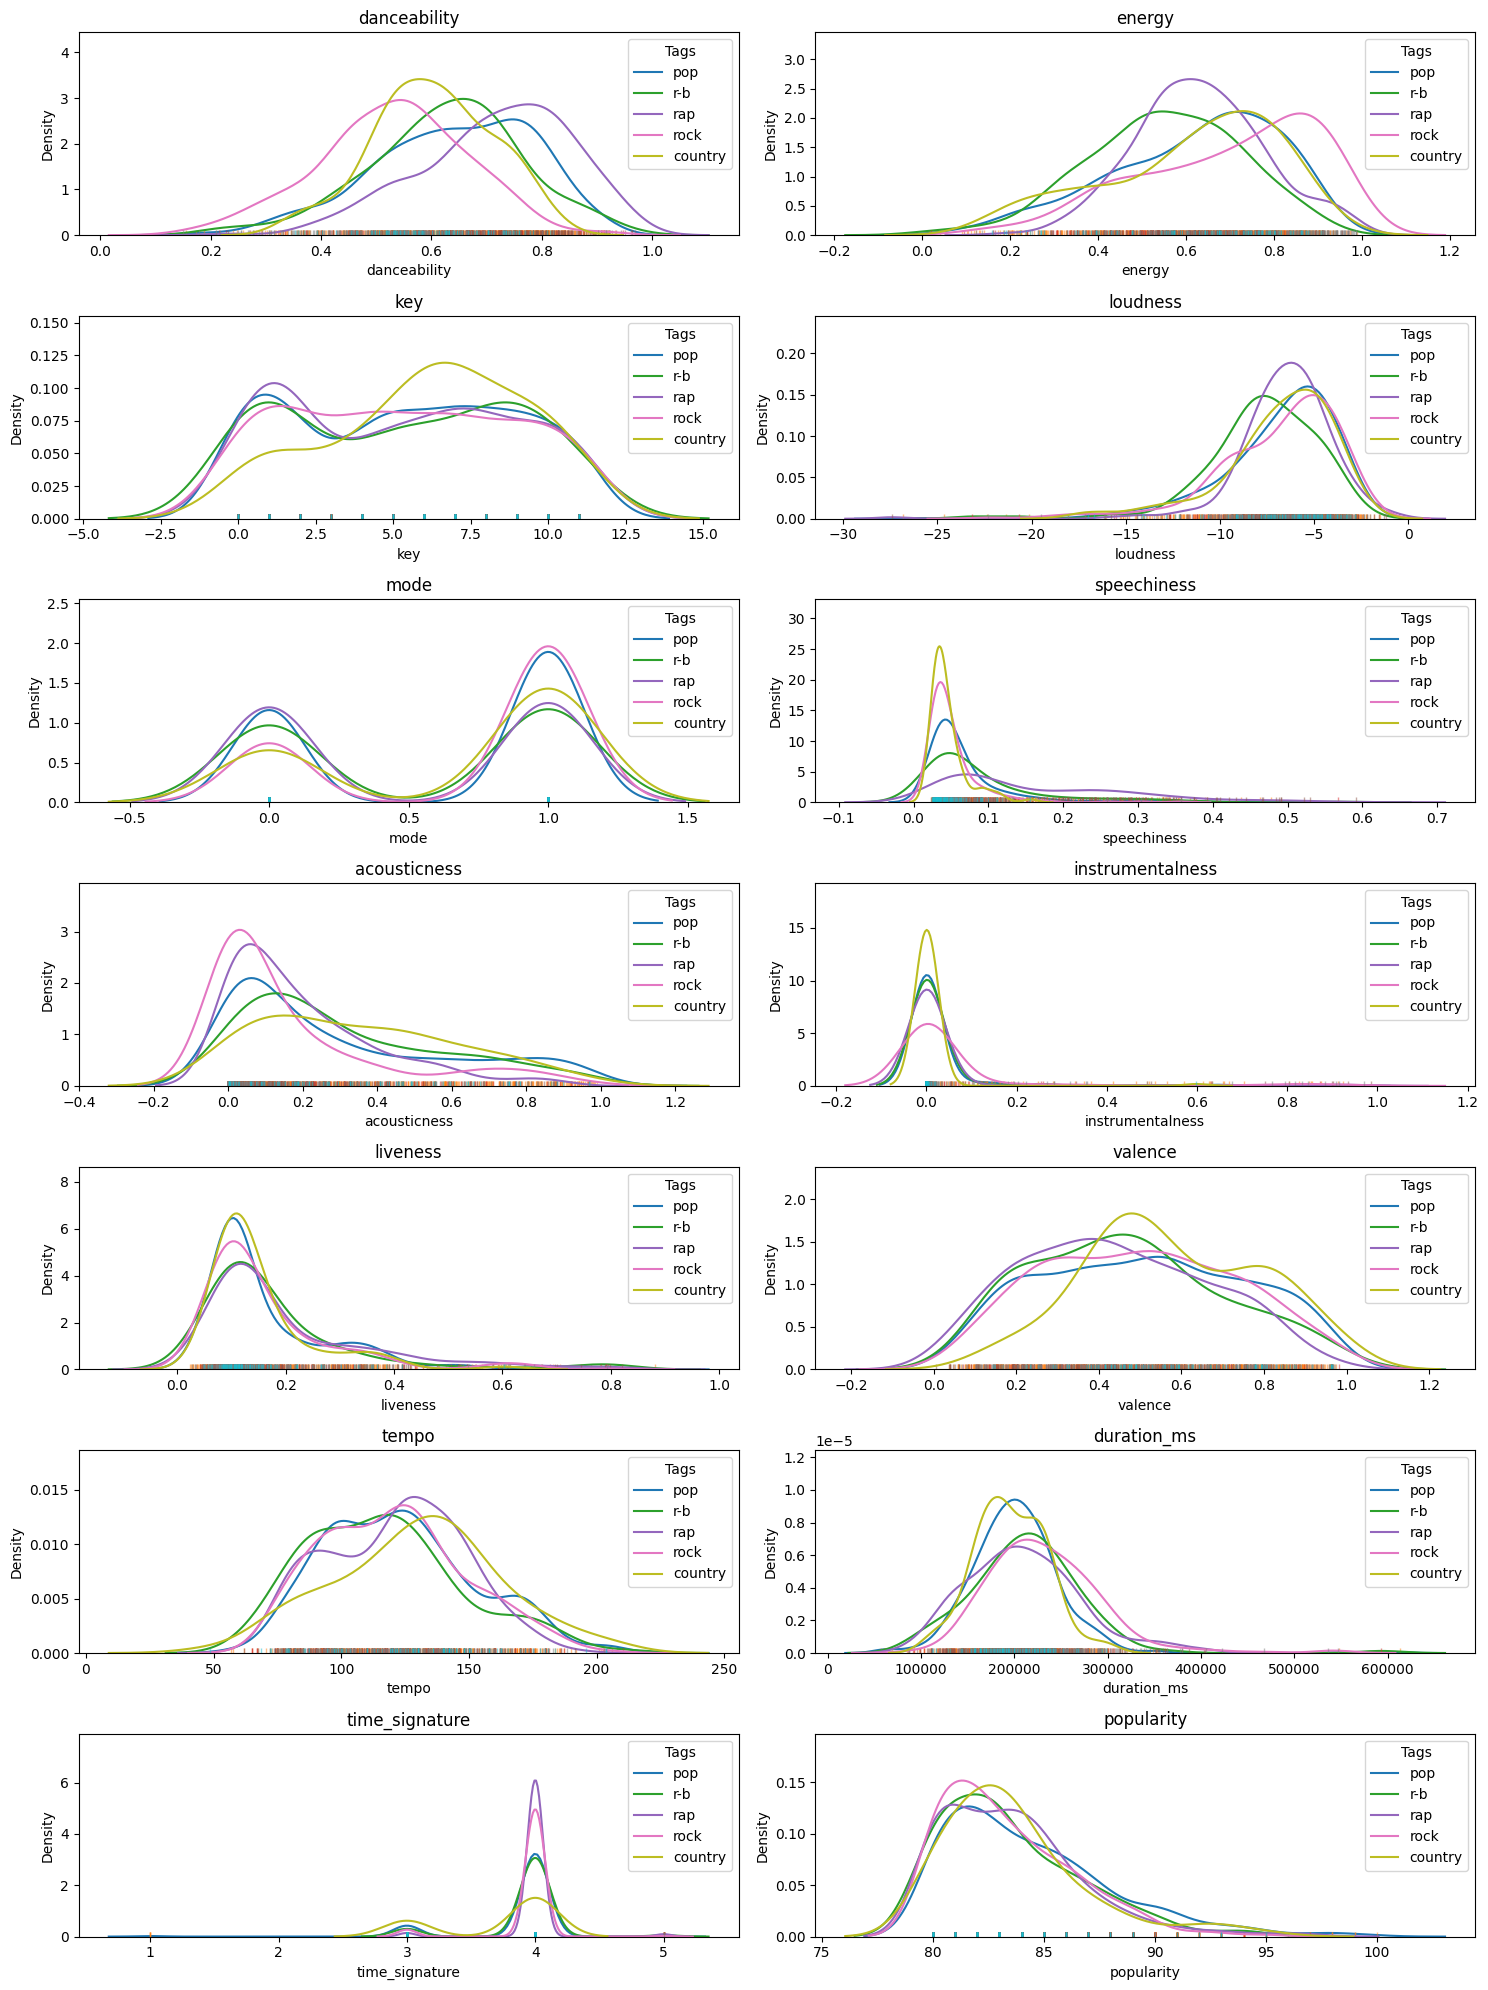

In [30]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['genius_id', 'released_year']]
fig, axs = plt.subplots(7,2, figsize=(15,20))
axs = axs.flatten()
for i, col in enumerate(numerical_cols):
    for tag in df['tags'].unique():
        sns.kdeplot(x=df[df['tags'] == tag][col], label=tag, ax=axs[i])
        sns.rugplot(x=df[df['tags'] == tag][col], alpha=0.5, ax=axs[i])
    axs[i].set_title(col)
    axs[i].set_xlabel(col)
    axs[i].legend(title='Tags')

plt.tight_layout()
plt.show()

# Biểu diễn các cột dạng category:

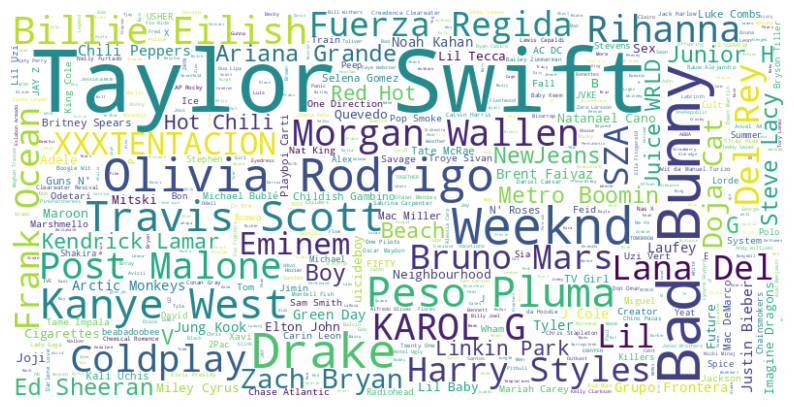

In [14]:
artists = ' '.join(df['artist_name'])
wordcloud = WordCloud(width=800, height=400, max_words=500, background_color='white').generate(artists)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Nhìn chung, trong các track có popularity cao trong data thu thập được, số lượng track được sáng tác nhiều nhất thuộc về những cái tên nổi tiếng như Taylor Swift, Olivia Rodrigo, Bad Bunny, Drake, Kanye West,...

## II. Phân tích dữ liệu:

## Câu hỏi 1: Số lượng nhạc và phân bố của các bài nhạc theo các năm

### Ta sẽ xem dữ liệu của ta phân bổ thế nào qua từng thập niên:

In [32]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade


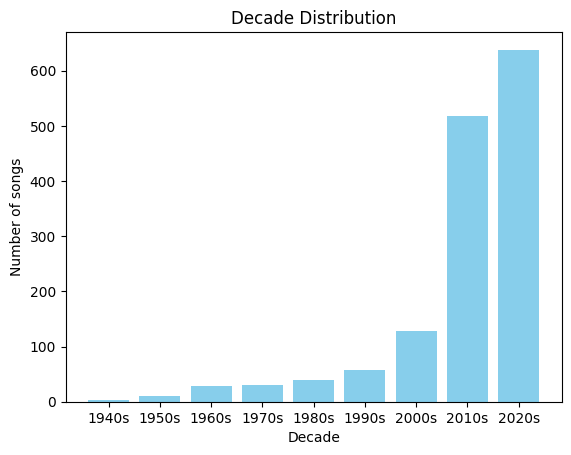

In [16]:
decade = df['released_year'].apply(lambda x : get_decade(x))
decade_index = decade.value_counts().index[::-1]
decade_value = decade.value_counts().values[::-1]

# Create a bar plot
plt.bar(decade_index, decade_value, color='skyblue')
plt.xlabel('Decade')
plt.ylabel('Number of songs')
plt.title('Decade Distribution')
plt.show()

**Nhận xét:** Có thể thấy dữ liệu của ta phân bố trong 2 thập niên gần đây

### Ta sẽ xem dữ liệu của ta phân bố thế nào qua từng năm trong 2 thập niên gần nhất 2010s và 2020s

In [34]:
df_2010_2023 = df[df['released_year'] >= 2010]
songs_2010_2023 = df_2010_2023['released_year'].value_counts().sort_index()

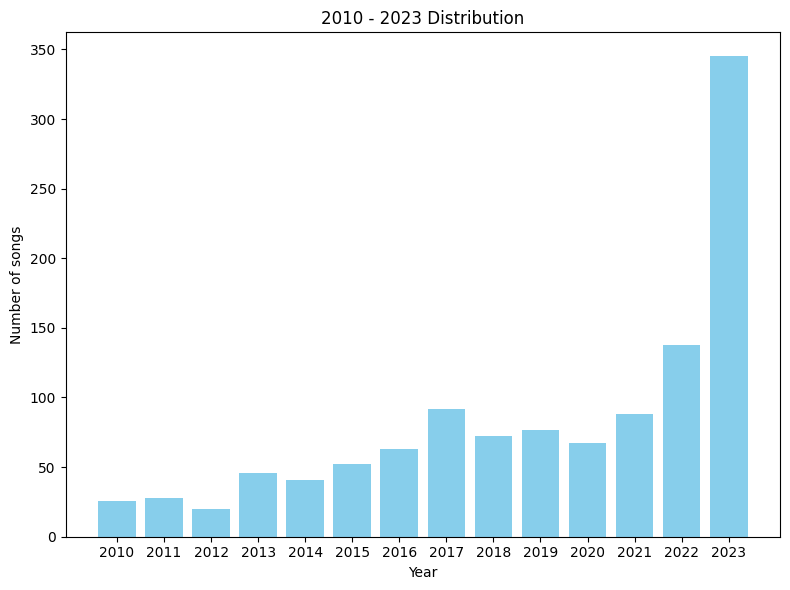

In [35]:
plt.figure(figsize=(8, 6))
plt.bar(songs_2010_2023.index,songs_2010_2023.values, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of songs')
plt.title('2010 - 2023 Distribution')
plt.xticks(songs_2010_2023.index)
plt.tight_layout()
plt.show()

**Thể loại thịnh hành từ 2010 - 2023**

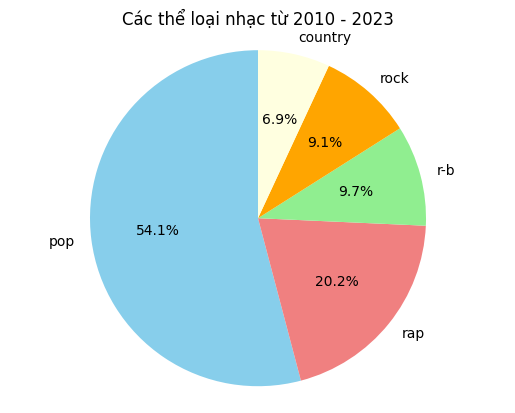

In [36]:
tags_2010_2023 = df_2010_2023['tags']
tags_count = tags_2010_2023.value_counts()
plt.pie(tags_count.values, labels=tags_count.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'lightyellow'])
plt.axis('equal')

plt.title('Các thể loại nhạc từ 2010 - 2023')
plt.show()

## Câu hỏi 2: Tương quan giữa các thuộc tính nhạc
- Trả lời cho việc: Những thuộc tính nào của bài nhạc có liên quan với nhau để cấu thành nên một bài hát.
- Cách tiếp cận: Vẽ bản đồ heatmap để so sánh và đánh giá.

Ta có tổng 13 thuộc tính của một bài nhạc như bên dưới

In [20]:
song_features = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms', 'time_signature']]

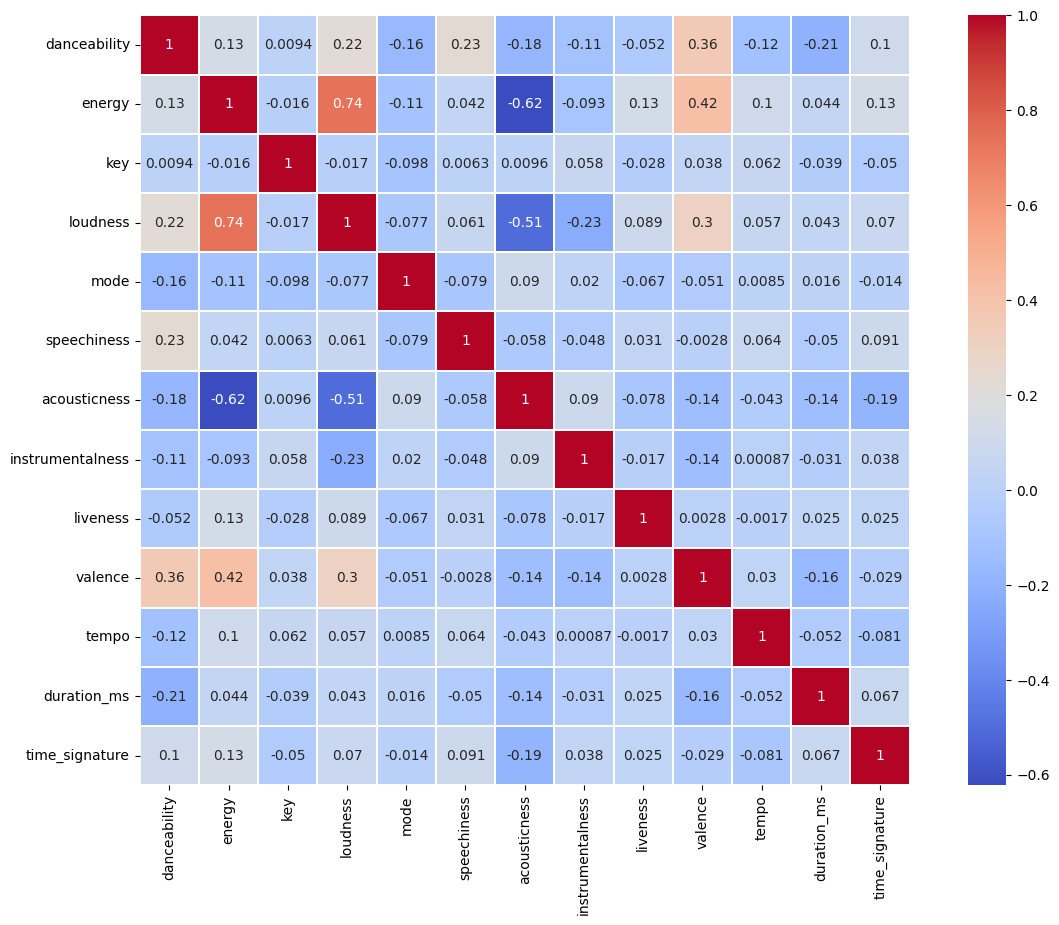

In [52]:
corr = song_features.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr,cmap = 'coolwarm',square = True ,linewidth = 0.2, linecolor = 'white',annot = True)
plt.show()

**Nhận xét:** Thông qua bảng có thể thấy, đa phần các nhóm dường như không quá liên quan. Các thuộc tính như key, mode, time_signature thiên về nhạc lý nên sẽ không bị ảnh hưởng bởi các thuộc tính kia.
- Có thể phân thành các nhóm có liên quan với nhau: loudness, energy, danceability và valence. Trong đó, energy và loudness dường như có tương quan mật thiết. Điều này dễ hiểu, thông thường âm nhạc càng lớn thì mức năng lượng của nó cũng mạnh mẽ theo. Một bài nhạc năng lượng sẽ khiến ta muốn nhún nhảy, vì thế cũng liên quan tới danceability. Về phần valence, một bài hát có ý nghĩa tích cực, kèm theo mức năng lượng lớn sẽ khiến cho bài nhạc trở nên tích cực hơn nữa và tạo nên một nguồn năng lượng tích cực.
- Thuộc tính acousticness lại mang phần ngược lại với nhóm trên. Acousticness là chỉ số của các nhạc cụ truyền thống. Thông thường, những nhạc cụ truyền thống mang lại cảm giác nhẹ nhàng và thiên hướng về nhịp điệu hơn là mang lại nguồn năng lượng lớn cũng như độ ồn tạo bởi các nhạc cụ điện tử khác.

## Câu hỏi 3: Thời lượng của các bài nhạc qua từng năm
- Trả lời cho việc : Xu hướng nghe nhạc của mọi người. Họ thích loại âm nhạc ngắn, nhanh hay dài dòng.

- Cách để tìm ra câu trả lời : Gom nhóm các bài hát lại theo dữ liệu từng năm, lấy dữ liệu duration_ms sau đó tính trung bình để đưa ra giá trị cần tìm. Với từng thể loại, sau khi gom nhóm theo năm, ta xét từng thể loại trong năm đó để đưa ra kết quả mong muốn.

**Thời lượng bài hát của tất cả các thể loại trong từng năm**

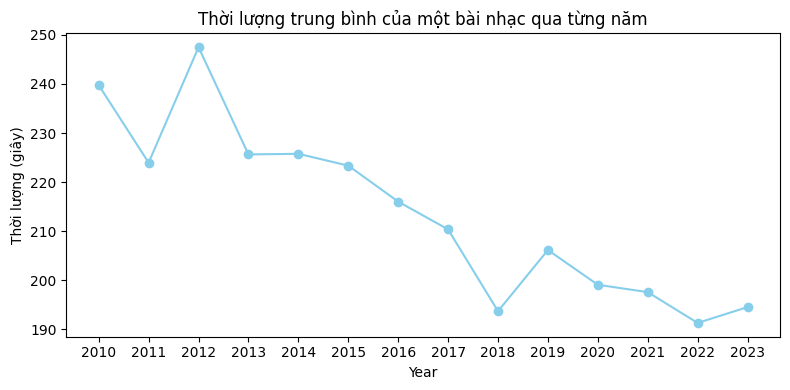

In [45]:
duration_per_year = df_2010_2023.groupby(['released_year'])['duration_ms'].mean()/1000
plt.figure(figsize = (8,4))
plt.plot(duration_per_year.index, duration_per_year.values, marker = 'o', color = 'skyblue')
plt.xlabel('Year')
plt.ylabel('Thời lượng (giây)')
plt.title('Thời lượng trung bình của một bài nhạc qua từng năm')
plt.xticks(duration_per_year.index)
plt.tight_layout()
plt.show()

**Thời lượng của từng thể loại nhạc qua từng năm**

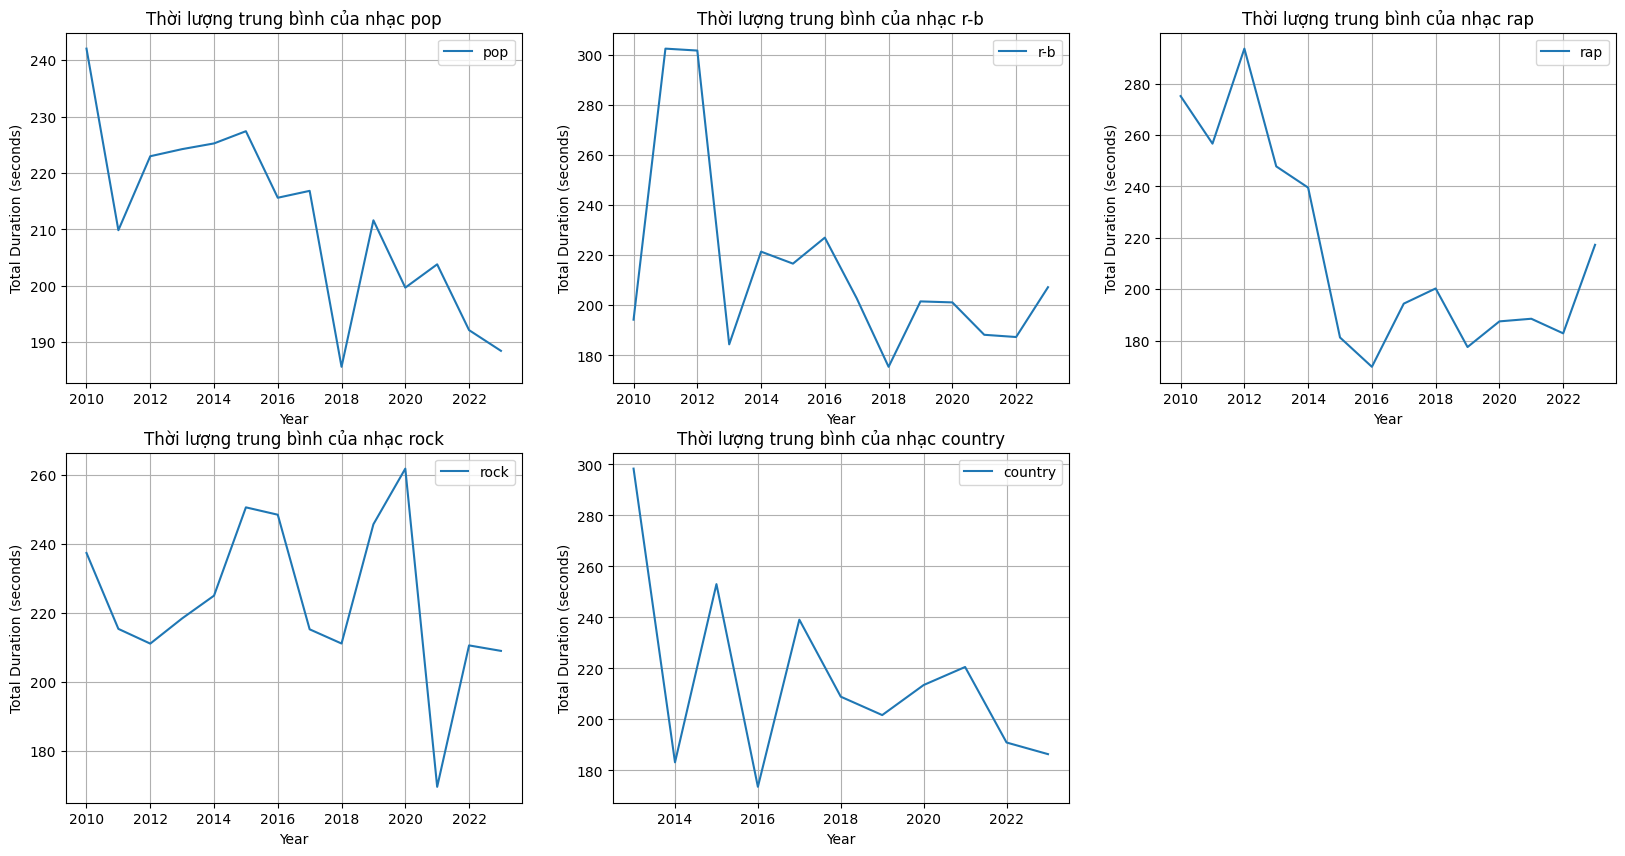

<Figure size 1000x400 with 0 Axes>

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
plt.figure(figsize =(10,4))
for i,genre in enumerate(df['tags'].unique()):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    genre_data = df_2010_2023[df_2010_2023['tags'] == genre].groupby('released_year')['duration_ms'].mean()/1000
    ax.plot(genre_data.index, genre_data.values, label=genre)

    ax.set_xlabel('Year')
    ax.set_ylabel('Total Duration (seconds)')
    ax.set_title(f'Thời lượng trung bình của nhạc {genre}')
    ax.legend()
    ax.grid(True)

axes.flatten()[5].axis('off')
plt.tight_layout()
plt.show()

**Nhận xét:**
Có thể thấy, xu hướng về thời lượng của bài hát là giảm dần. Việc này có nhiều nguyên nhân xuất phát bởi thị trường âm nhạc:
- Thời lượng ngắn dễ tiếp cận với người nghe và quảng bá. Việc có thời lượng ngắn giúp việc quảng bá những đoạn hay nhất cho người nghe trở nên dễ hơn.
- Tăng lượt nghe : Một bài nhạc ngắn sẽ giúp cho việc stream nhạc (tức nghe lại nhiều lần) trở nên dễ hơn và tiết kiệm thời gian hơn. Từ đó, giúp cho thành tích của tác phẩm âm nhạc trên nền tảng số Spotify được cải thiện.

## Câu hỏi 4: Các đặc trưng của bài nhạc.
Trả lời cho việc: Mỗi thể loại nhạc thì mang những đặc trưng gì. Ví dụ, nhạc Rock thì mạnh mẽ, ồn ào. Nhạc Country thì thường được nhận xét là du dương, nhẹ nhàng.

Cách tìm câu trả lời : Ta sẽ xét dựa trên thông số. Dùng biểu đồ mạng để cho thấy đặc trưng riêng của từng dòng nhạc.

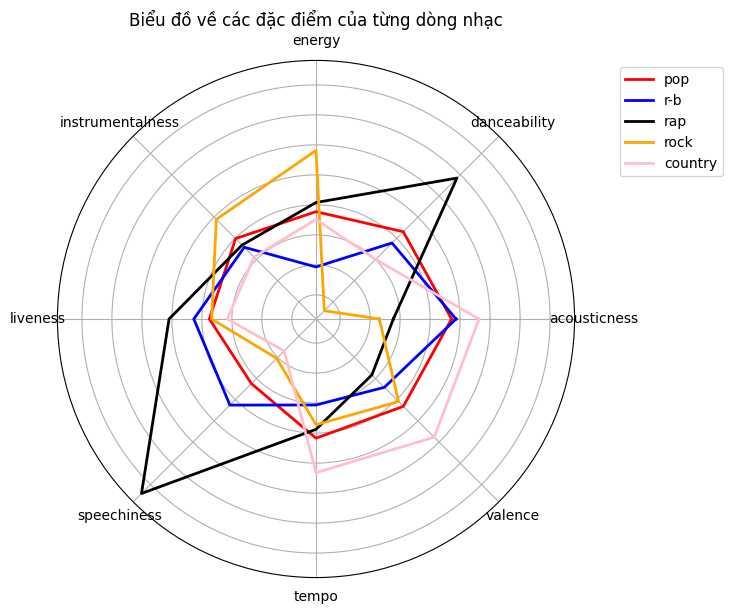

In [47]:
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']
df_plot = df[audio_features].copy()
tags = df['tags'].unique()

scaler = StandardScaler()
df_plot = scaler.fit_transform(df_plot)
df_plot = pd.DataFrame(df_plot, columns=audio_features)
df_plot['tags'] = df['tags']

data_values = []
for tag in tags:
    tag_data = df_plot[df_plot['tags'] == tag][audio_features].mean().values.tolist()
    data_values.append(tag_data)

data_values = np.array(data_values)

angles = np.linspace(0, 2 * np.pi, len(audio_features), endpoint=False).tolist()
angles += angles[:1]

custom_colors = ['red', 'blue', 'black', 'orange', 'pink']
tag_color_map = {tag: color for tag, color in zip(tags, custom_colors)}

fig, ax = plt.subplots(subplot_kw=dict(polar=True), figsize=(8, 6))

for i, values in enumerate(data_values):
    values = np.concatenate((values, [values[0]]))
    tag = tags[i]
    color = tag_color_map[tag]
    ax.plot(angles, values, linestyle='-', linewidth=2, color=color, label=tag)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(audio_features)
ax.set_yticklabels([])
ax.grid(True)
ax.legend(tags, loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.title('Biểu đồ về các đặc điểm của từng dòng nhạc')
plt.show()

**Nhận xét** :
- Về nhạc Rap: Rap thường được biết đến với việc có lời bài hát dày đặc để thể hiện tiếng nói mà người nghệ sĩ muốn truyền đạt. Dựa trên biểu đồ ta cũng có thể thấy, thông số speechiness (mức độ về giọng nói) trong các bài nhạc rap sẽ thể hiện rõ rệt. Bên cạnh đó, nhạc Rap theo xu hướng mới thường có những nhạc nền mang xu hướng sôi động, phù hợp để 'quẩy' thể hiện qua thông số danceability cao.

- Về nhạc Rock: Rock thường phổ biến với đặc trưng về kết hợp của các nhạc cụ: trống, bass, guitar,... Vì thế, đặc trưng instrumentalness của Rock được thể hiện khá rõ qua mô hình. Đồng thời, dòng nhạc Rock được xem là mạnh mẽ, sôi động, nhiều năng lượng nên đặc trưng Energy của dòng nhạc này cũng được thể hiện.

- Về nhạc Country (nhạc đồng quê): được biết đến với giai điệu nhẹ nhàng. Nhạc đồng quê thường gắn liền với những nhạc cụ truyền thống: guitar, trống, vĩ cầm, harmonica cùng giai điệu bắt tai và vui vẻ. Bên cạnh đó, nhạc đồng quê thường gắn liền với những đề tài liên quan tới tình yêu, gia đình và những điều mộc mạc, tạo nên sự giản dị cho dòng nhạc. Những điều này thể hiện qua Valence (tính tích cực của ý nghĩa bài hát) và Acousticness (tức mức độ nhạc cụ truyền thống trong bài).

- Về nhạc r&b: R&B tức là Rhytms and Blues, nhịp điệu và tâm trạng. Ngay từ chính cái tên của dòng nhạc cũng đã thể hiện đặc trưng của dòng nhạc. Dòng nhạc này thường có xu hướng nhẹ nhàng, cùng với phần nhịp điệu bắt tai từ những nhạc cụ như guitar, harmonica và các loại kèn. Vì thế, qua biểu đồ, phần acousticness của r&b là điểm mạnh đặc trưng.

- Về nhạc pop: pop là từ viết tắt của popular. Ngay từ chính điều này đã thể hiện, đây là dòng nhạc phổ biến, tức hợp gu nhạc đại chúng. Từ biểu đồ có thể thấy rằng, hình vẽ của Pop có thiên hướng tròn và bao phủ mọi phía. Tức có nghĩa, pop tổng hòa mọi điều. Pop có phần âm hưởng tốt, lời nhạc ý nghĩa, năng lượng và cũng phù hợp để 'quẩy'. Vì mang trong mình những điểm rất phổ thông như vậy, nhạc pop dễ dàng chiếm được thị hiếu người nghe khi gần như có thể đáp ứng hài hòa nhu cầu của thính giả.

## Câu hỏi 5: Thể loại nào dễ tạo ra trending nhất? Nêu 5 bài nhạc nổi tiếng nhất của từng thể loại.

Trả lời cho việc: Tìm hiểu dòng nhạc nào được ưa chuộng nhất. Xếp hạng, so sánh các bài nhạc trending thuộc các thể loại khác nhau.
Cách tìm câu trả lời : Ta sẽ xét dựa trên thông số. Dùng biểu đồ boxplot để so sánh độ nổi của các dòng nhạc, sau đó dùng barplot thể hiện top 5 popularity của các bài nhạc theo tags.

1) Boxplot của các thể loại nhạc theo popularity:

In [48]:
df_new = df.groupby('tags').mean()['popularity']
df_new

<ipython-input-48-efe69bacca06>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_new = df.groupby('tags').mean()['popularity']


tags
country    83.651163
pop        84.388652
r-b        83.481752
rap        83.533333
rock       83.333333
Name: popularity, dtype: float64

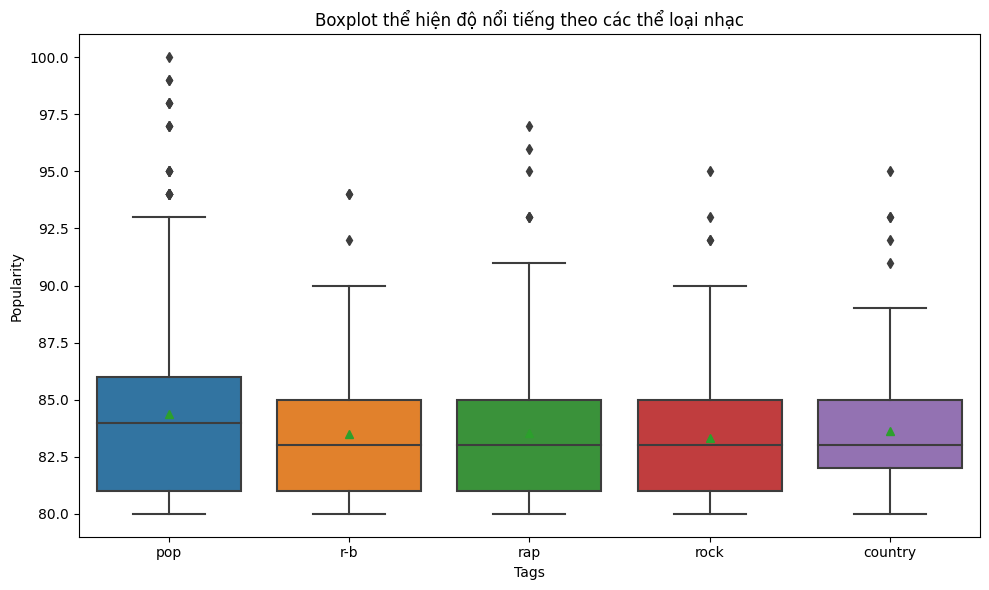

In [49]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='tags', y='popularity', showmeans=True)
plt.title("Boxplot thể hiện độ nổi tiếng theo các thể loại nhạc")
plt.xlabel("Tags")
plt.ylabel("Popularity")
plt.tight_layout()
plt.show()

**Nhận xét**:
Biểu đồ trên sử dụng biểu đồ boxplot để thể hiện độ nổi tiếng của các thể loại nhạc pop, R&B, rap, rock và country. Ta có thể thấy được:

- Thể loại nhạc pop có độ nổi tiếng cao nhất, với giá trị trung bình là cao nhất khoảng 84 cùng với giá trị max và các outliers cao hơn hẳn các thể loại khác. Mặt khác, country không có những bài nhạc nổi trội (outliers) có thể so sánh với các thể loại khác.
- Thể loại nhạc country có độ nổi tiếng cao thứ nhì, với giá trị trung bình là 83,6, chỉ sau nhạc pop, nhưng tứ phân vị thứ nhất lại cao hơn hẳn pop và các thể loại còn lại.
- Thể loại nhạc r-b, rap và rock có độ nổi tiếng tương đương nhau, với giá trị trung bình ở khoảng 83, tuy nhiên rap sẽ chênh hơn một chút.


Nhìn chung, các thể loại nhạc phổ biến đều có giá trị trung bình trên 82, cho thấy chúng đều được yêu thích bởi nhiều người. Tuy nhiên, thể loại nhạc pop vẫn là thể loại được yêu thích nhất, với khoảng cách khá lớn so với các thể loại khác.

In [50]:
top_songs_by_tags = df.groupby('tags')['song_name', 'popularity', 'artist_name'].apply(lambda x: x.nlargest(5, 'popularity'))
top_songs_by_tags

<ipython-input-50-58b1b3e7a5b5>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  top_songs_by_tags = df.groupby('tags')['song_name', 'popularity', 'artist_name'].apply(lambda x: x.nlargest(5, 'popularity'))


song_name  popularity  \
tags                                                                       
country 220                                     HARLEY QUINN          95   
        558                                 Jingle Bell Rock          93   
        658                                        LADY GAGA          93   
        85                                             Lover          92   
        614                          Something in the Orange          91   
pop     1167                                          greedy         100   
        613                  All I Want for Christmas Is You          99   
        1166                                    Cruel Summer          99   
        615                            My Love Mine All Mine          98   
        844                             Standing Next to You          98   
r-b     97    One Of The Girls (with JENNIE, Lily Rose Depp)          94   
        752                                          Starboy          94   
        741                                     Pink + White          92   
        5                                        Die For You          90   
        281                                       Sure Thing          90   
rap     1375                                     Lovin On Me          97   
        1054                                          MONACO          96   
        29                                Paint The Town Red          95   
        21                                IDGAF (feat. Yeat)          93   
        26                                       Agora Hills          93   
rock    903                                 I Wanna Be Yours          95   
        620                                  Sweater Weather          93   
        904                                        Anti-Hero          92   
        1025                                          Yellow          92   
        10                                  Do I Wanna Know?          90   

                    artist_name  
tags                             
country 220       Fuerza Regida  
        558         Bobby Helms  
        658          Peso Pluma  
        85         Taylor Swift  
        614          Zach Bryan  
pop     1167         Tate McRae  
        613        Mariah Carey  
        1166       Taylor Swift  
        615              Mitski  
        844           Jung Kook  
r-b     97           The Weeknd  
        752          The Weeknd  
        741         Frank Ocean  
        5            The Weeknd  
        281              Miguel  
rap     1375        Jack Harlow  
        1054          Bad Bunny  
        29             Doja Cat  
        21                Drake  
        26             Doja Cat  
rock    903      Arctic Monkeys  
        620   The Neighbourhood  
        904        Taylor Swift  
        1025           Coldplay  
        10       Arctic Monkeys

2) Barplot thể hiện top 5 các bài nhạc theo thể loại:

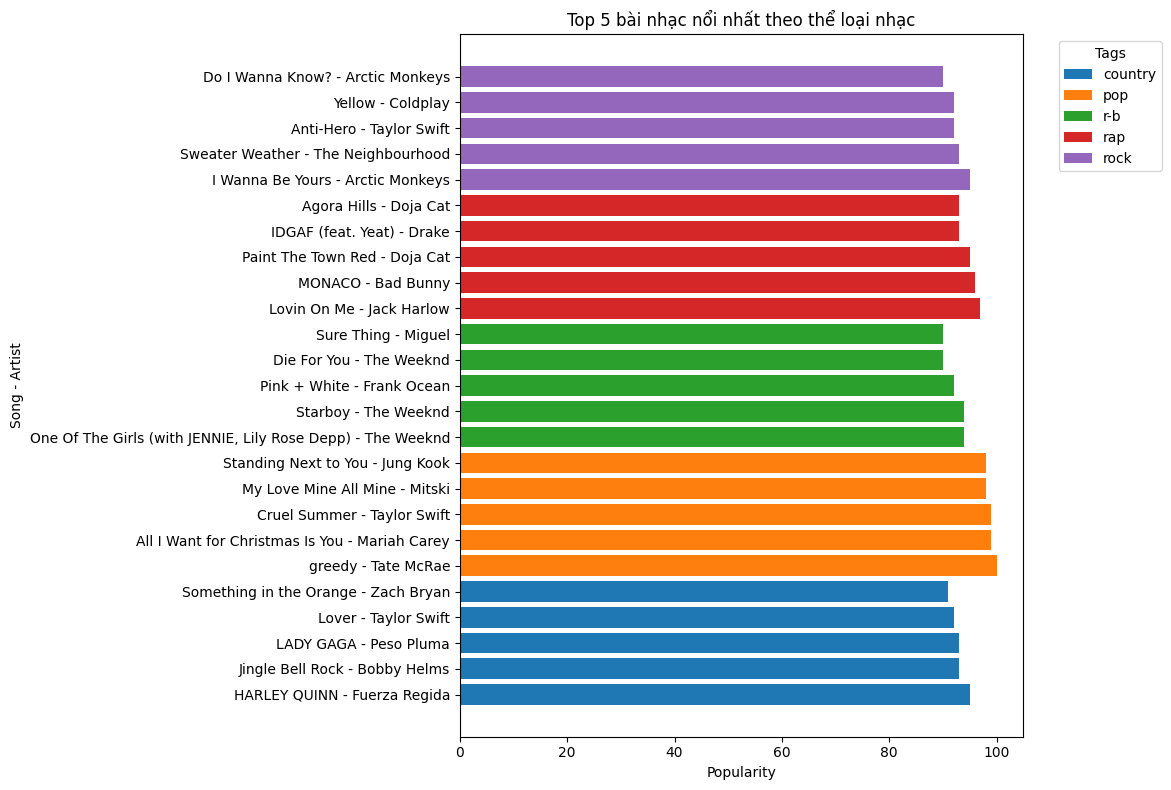

In [51]:
plt.figure(figsize=(12, 8))
for tag, group in top_songs_by_tags.groupby('tags'):
    plt.barh([f"{song} - {artist}" for song, artist in zip(group['song_name'], group['artist_name'])], group['popularity'], label=tag)

plt.xlabel('Popularity')
plt.ylabel('Song - Artist')
plt.title('Top 5 bài nhạc nổi nhất theo thể loại nhạc')
plt.legend(title='Tags', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Nhận xét**:

- Ở rock: Dẫn đầu là "I Wanna Be Yours' của Arctic Monkeys, theo sau là "Sweater Weather" của The Neighbourhood, "Anti-Hero" của Taylor Swift, "Yellow" của ColdPlay, và đứng cuối trong 5 bài top là "Do I Wanna Know?" của Arctic Monkeys. Arctic Monkeys góp 2 bài nhạc trong top thể loại rock, điều này cho thấy Arctic Monkeys là một ban nhạc có độ nổi tiếng cao trong giới nhạc rock.

- Ở pop, "greedy" của Tate McRae dẫn đầu với độ nổi tiếng bằng 100, "All I Want for Christmas Is You" của Mariah Carey chỉ thua kém một chút, ngang bằng với "Cruel Summer" của Taylor Swift. 2 bài nhạc cuối cũng ngang nhau về độ nổi đó là "My Love Mine All Mine" của Mitski và "Standing Next to You" của Jung Kook.

- Ở rap, gồm có "Lovin On Me" - Jack Harlow dẫn đầu, nối theo sau là "MONACO" của Bad Bunny, "Paint The Town Red" của Doja Cat, "IDGAF" của Drake, và một lần nữa "Agora Hills" của Doja Cat. Doja Cat có hai bài trong top nhạc này.

- Ở r-b, thứ nhất, thứ hai và thứ tư thuộc về The Weeknd với 3 bài "One Of The Girls", "Starboy", "Die For You". "Pink + White" của Frank Ocean và "Sure Thing" của Miguel cũng có độ nổi không thua kém.

- Ở country, "HARLEY QUINN" của Fuerza Regida đứng nhất, theo sau là "Jingle Bell Rock" của Bobby Helms, "LADY GAGA" của Peso Pluma, "Lover" của Taylor Swift, và cuối cùng là "Something in the Orange" của Zach Bryan.

Các bài nhạc có độ nổi tiếng cao hầu như là của các nghệ sĩ nổi tiếng. Có Taylor Swift có tên của trong top 5 của cả 3 thể loại. The Weeknd, Doja Cat hay Arctic Monkeys xuất hiện nhiều lần trong thể loại nhạc của mình, thể hiện được tầm nổi tiếng của mình trong lĩnh vực âm nhạc ấy.

#Sườn bài

- Phân bố của từng cột. Box plot.
- year : Vẽ histogram (Lấy decade).
- Thuộc tính nhạc : Vẽ boxplot.


Artist : Vẽ biểu đồ tròn.

Câu hỏi 1: Sự tương quan giữa các nhóm thuộc tính nhạc?

Câu hỏi 2: Thể loại nhạc phổ biến theo từng thời kì?

Câu hỏi trả lời cho việc xu hướng nhạc của cộng đồng thay đổi theo từng mốc thời gian?

Câu hỏi 3: Thời lượng trung bình của các thể loại nhạc?

Câu hỏi trả lời cho việc một thể loại nhạc mang những đặc trưng nào?

Câu hỏi 4: Các thuộc tính của nhạc theo từng tags.

Câu hỏi 5: Thể loại nào dễ tạo ra trending nhất? Nêu 5 bài nhạc nổi tiếng nhất của từng thể loại.







